In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna

https://archive.ics.uci.edu/ml/datasets/wine+quality

In [2]:
data = pd.read_csv('winequality-red.csv', sep = ';')

1.Разделите выборку на обучающую и тестовую в отношении 70%/30%

In [3]:
X = data.iloc[:,:11]
y = data['quality']
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1119, 11), (480, 11), (1119,), (480,))

2.Оцените качество по метрике accuracy для классификаторов:

DecisionTreeClassifier

BaggingClassifier со 100 деревьями

RandomForestClassifier со 100 деревьями

Сравните результаты и напишите какой вывод можно сделать.

In [4]:
%%time
DecTree = DecisionTreeClassifier(random_state=RANDOM_STATE)
DecTree.fit(X_train, y_train)
y_pred_d = DecTree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_d)
print(accuracy)

0.5729166666666666
Wall time: 42.5 ms


In [5]:
%%time
BagClass = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                           n_estimators=100,
                           random_state=RANDOM_STATE)
BagClass.fit(X_train, y_train)
y_pred_d = BagClass.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_d)
print(accuracy)

0.6416666666666667
Wall time: 457 ms


In [6]:
%%time
RandFor = RandomForestClassifier(random_state=RANDOM_STATE)
RandFor.fit(X_train, y_train)
y_pred_d = RandFor.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_d)
print(accuracy)

0.6541666666666667
Wall time: 223 ms


In [ ]:
Ансамблевые методы работают лучше, но простое дерево работает быстрее

3.Посчитайте качество на тестовой выборке по метрике accuracy для классификатора RandomForestClassifier, используя значения деревьев:
    
10, 50, 100, 200, далее с шагом 200 до 5000 деревьев.
Постройте график зависимости качества от числа деревьев.



In [8]:
estimators_num = [10, 50, 100] + list(np.arange(200, 5000, 200))

In [9]:
%%time
accuracy = []
for n in estimators_num :
    RFC = RandomForestClassifier(n_estimators=n, random_state=42)
    RFC.fit(X_train, y_train)
    accuracy.append(RFC.score(X_test, y_test))

Wall time: 2min 6s


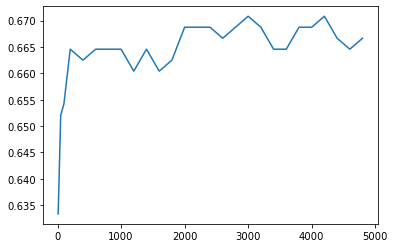

In [10]:
plt.plot(estimators_num, accuracy)

4.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек sklearn и xgboost. Сравните значение метрики accuracy по cross_val_score

In [11]:
LabEn = LabelEncoder()
y_train_le = LabEn.fit_transform(y_train)
y_test_le = LabEn.transform(y_test)

In [12]:
%%time
GBC = GradientBoostingClassifier(random_state=42)
scores_GBC = cross_val_score(GBC, X_train, y_train_le, scoring='accuracy')
print(scores_GBC.mean())

0.6434857463164638
Wall time: 4.82 s


In [13]:
%%time
XGB = XGBClassifier(random_state=42)
scores_XGB = cross_val_score(XGB, X_train, y_train_le, scoring='accuracy')
print(scores_XGB.mean())

0.643461723254324
Wall time: 946 ms


In [ ]:
XGB отрабатывает быстрее, но результат равен до 4 символов после запятой

5.Подберите оптимальные параметры этих алгоритмов с помощью GridSearchCV(cv=3).
Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните значение метрики accuracy и скорость работы. Выведите лучшие параметры алгоритмов.

In [14]:
params = {'learning_rate': [0.01, 0.1, 0.2, 0.3], 
              'n_estimators':[1, 10, 25, 50, 100, 250, 500],
              'max_depth': np.arange(3,5,1)
              }

In [15]:
%%time

GS_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), cv=3, param_grid=params, scoring='accuracy')
GS_GBC.fit(X_train, y_train)
y_pred_d = GS_GBC.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_d)
print(accuracy)
print(GS_GBC.best_params_)

0.6520833333333333
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
Wall time: 3min 36s


In [16]:
%%time

GS_XGB = GridSearchCV(XGBClassifier(random_state=42), cv=3, param_grid=params, scoring='accuracy')
GS_XGB.fit(X_train, y_train_le)
y_pred_d = GS_XGB.predict(X_test)
accuracy = accuracy_score(y_test_le, y_pred_d)
print(accuracy)
print(GS_XGB.best_params_)

0.6458333333333334
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 250}
Wall time: 29.7 s


In [ ]:
XGB быстрее, GradientBoostingClassifier лучше качеством, но результат RandomForestClassifier не превзойден.

6.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек lightgbm и catboost. Сравните значение метрики accuracy по cross_val_score по всем четырем реализациям.

In [19]:
%%time
LGBM = LGBMClassifier()
LGBM.fit(X_train, y_train)
scores_LGBM = cross_val_score(LGBM, X_train, y_train, scoring='accuracy')
print(scores_LGBM.mean())

0.6398822869955157
Wall time: 1.24 s


In [20]:
%%time
CatBoost = CatBoostClassifier(random_state=42, verbose=False)
CatBoost.fit(X_train, y_train)
scores_CatBoost = cross_val_score(CatBoost, X_train, y_train, scoring='accuracy')
print(scores_CatBoost.mean())

0.6577714606021781
Wall time: 20 s


In [ ]:
CatBoostClassifier показал лучший результат

7.Подберите оптимальные параметры для алгоритмов градиентного бустинга из библиотек lightgbm и catboost с теми же условиями. Выведите лучшие параметры алгоритмов.
Сравните значение метрики accuracy и скорость по этим четырем реализациям.

In [21]:
params = {'learning_rate': [0.01, 0.1, 0.2, 0.3], 
              'n_estimators':[1, 10, 25, 50, 100, 250, 500],
              'max_depth': np.arange(3,5,1)
              }

In [22]:
%%time

GS_LGBMC = GridSearchCV(LGBMClassifier(), cv=3, param_grid=params, scoring='accuracy')
GS_LGBMC.fit(X_train, y_train)
y_pred_d = GS_LGBMC.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_d)
print(accuracy)
print(GS_LGBMC.best_params_)

0.6604166666666667
{'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 50}
Wall time: 15.3 s


In [23]:
%%time

GS_CatBoost = GridSearchCV(CatBoostClassifier(random_state=42, verbose=False), cv=3, param_grid=params, scoring='accuracy')
GS_CatBoost.fit(X_train, y_train)
y_pred_d = GS_CatBoost.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_d)
print(accuracy)
print(GS_CatBoost.best_params_)

0.60625
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
Wall time: 25.8 s


In [ ]:
Лучшее качество и скорость у LGBMClassifier

8.Подберите оптимальные параметры алгоритма из библиотеки xgbost с помощью [optuna](https://github.com/optuna/optuna) . Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните результат с поиском по сетке из sklearn. Выведите лучшие параметры алгоритма, найденные даным способом.

In [24]:
%%time
def objective(trial):

    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 1, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'random_state': 42
    }

    XGB_opt = XGBClassifier(**params)
    scores = cross_val_score(XGB_opt, X_train, y_train_le, scoring='accuracy').mean()

    return scores



study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100)

[I 2022-11-16 21:58:41,903] A new study created in memory with name: no-name-086ef184-1d6d-4ebd-93ac-5152a1470262
[I 2022-11-16 21:58:44,317] Trial 0 finished with value: 0.643461723254324 and parameters: {'learning_rate': 0.2565131228458855, 'n_estimators': 324, 'max_depth': 7}. Best is trial 0 with value: 0.643461723254324.
[I 2022-11-16 21:58:45,049] Trial 1 finished with value: 0.6586643177450352 and parameters: {'learning_rate': 0.18916018593384726, 'n_estimators': 79, 'max_depth': 5}. Best is trial 1 with value: 0.6586643177450352.
[I 2022-11-16 21:58:47,011] Trial 2 finished with value: 0.6595691864189621 and parameters: {'learning_rate': 0.07351106129112385, 'n_estimators': 189, 'max_depth': 6}. Best is trial 2 with value: 0.6595691864189621.
[I 2022-11-16 21:58:47,265] Trial 3 finished with value: 0.637231742472774 and parameters: {'learning_rate': 0.2794290096863307, 'n_estimators': 23, 'max_depth': 5}. Best is trial 2 with value: 0.6595691864189621.
[I 2022-11-16 21:58:50,23

[I 2022-11-16 22:00:07,755] Trial 35 finished with value: 0.5871836963484945 and parameters: {'learning_rate': 0.07468869035764775, 'n_estimators': 1, 'max_depth': 7}. Best is trial 18 with value: 0.6675928891736066.
[I 2022-11-16 22:00:08,501] Trial 36 finished with value: 0.6586603139013454 and parameters: {'learning_rate': 0.29876728580471934, 'n_estimators': 66, 'max_depth': 6}. Best is trial 18 with value: 0.6675928891736066.
[I 2022-11-16 22:00:09,687] Trial 37 finished with value: 0.6479500320307495 and parameters: {'learning_rate': 0.02833244855685459, 'n_estimators': 92, 'max_depth': 7}. Best is trial 18 with value: 0.6675928891736066.
[I 2022-11-16 22:00:10,357] Trial 38 finished with value: 0.6586563100576555 and parameters: {'learning_rate': 0.05971780458126151, 'n_estimators': 41, 'max_depth': 9}. Best is trial 18 with value: 0.6675928891736066.
[I 2022-11-16 22:00:11,957] Trial 39 finished with value: 0.6586683215887252 and parameters: {'learning_rate': 0.1133196380143456

[I 2022-11-16 22:02:07,348] Trial 71 finished with value: 0.6595491672005125 and parameters: {'learning_rate': 0.042325112631663435, 'n_estimators': 209, 'max_depth': 8}. Best is trial 64 with value: 0.669378603459321.
[I 2022-11-16 22:02:08,923] Trial 72 finished with value: 0.6676169122357464 and parameters: {'learning_rate': 0.03587830025282372, 'n_estimators': 110, 'max_depth': 8}. Best is trial 64 with value: 0.669378603459321.
[I 2022-11-16 22:02:12,860] Trial 73 finished with value: 0.662227738629084 and parameters: {'learning_rate': 0.034915765488848546, 'n_estimators': 304, 'max_depth': 8}. Best is trial 64 with value: 0.669378603459321.
[I 2022-11-16 22:02:16,335] Trial 74 finished with value: 0.6577594490711082 and parameters: {'learning_rate': 0.05954356862538546, 'n_estimators': 285, 'max_depth': 8}. Best is trial 64 with value: 0.669378603459321.
[I 2022-11-16 22:02:17,310] Trial 75 finished with value: 0.6604540358744394 and parameters: {'learning_rate': 0.06919758043037

Wall time: 4min 45s


In [25]:
print(study.best_value)
print(study.best_params)

0.6711923446508649
{'learning_rate': 0.014862322235361429, 'n_estimators': 280, 'max_depth': 8}


In [ ]:
Optuna показала лучший результат по качеству.

9.Выведите качество по метрике accuracy стэкинга (StackingClassifier) 4-х алгоритмов с базовыми параметрами градиентного бустинга.

In [26]:
%%time
estimators = [
    ('GBC', GradientBoostingClassifier(random_state=42)),
    ('XGBC', XGBClassifier(random_state=42)),
    ('LGBMC', LGBMClassifier(random_state=42)),
    ('CBC', CatBoostClassifier(random_state=42, verbose=False))
]
StackClass = StackingClassifier(estimators=estimators)
scores = cross_val_score(StackClass, X_train, y_train_le, scoring='accuracy').mean()
print(scores)

0.6667160474055093
Wall time: 2min 13s


10.Выведите качество по метрике accuracy стэкинга 4-х алгоритмов с оптимальными параметрами градиентного бустинга. Сравните результаты с предыдущим шагом и напишите какой вывод можно из этого сделать.

In [27]:
%%time
estimators = [
    ('GBC', GradientBoostingClassifier(**GS_GBC.best_params_, random_state=42)),
    ('XGBC', XGBClassifier(**GS_XGB.best_params_, random_state=42)),
    ('LGBMC', LGBMClassifier(**GS_XGB.best_params_, random_state=42)),
    ('CBC', CatBoostClassifier(**GS_CatBoost.best_params_, random_state=42, verbose=False))
]
bestStackClass = StackingClassifier(estimators=estimators)
scores = cross_val_score(bestStackClass, X_train, y_train_le, scoring='accuracy').mean()
print(scores)

0.6658111787315824
Wall time: 2min 7s


In [ ]:
Использование лучших моделей несколько снизило результат